# EDA

This notebook contains all the exploratory work done for the project.

First, we will sanitize and clean by doing a thorough exploration of  the dataset. Looking into each feature –specially the categorical ones– and their respective values. Here, our goal will be to understand how the possible values for each feature are distributed, what does an empty or null value represent for each feature and how should we treat it. As a result, we might end up filling in the missing values, removing the samples in conflict or even dropping the feature altogether.

Then, we will explore the possible correlations between feature, if any.

Finally, we will implement a quick version of PCA to see if there's any latent feature we could leverage for the classification of crashes

All these steps will lead us t a curated dataset suitable for the classifiers we will build on another notebook.

## 1. Initialization and Data Loading

First, lets import all the libraries we will use in this notebook and define some utility functions.

In [1]:
# Imports and initial setup

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

from utils import *

%matplotlib inline

In [2]:
# Read original dataset
crash_data = pd.read_csv('data/Crash_Analysis_System_CAS_data.csv')

In [3]:
print('The dataset has {:3,d} samples and {} features'.format(*crash_data.shape))

The dataset has 655,697 samples and 89 features


## 2 Removal of Non Relevant Features

Our dataset is quite big, but still manageable without resorting to the cloud or parallel computing techniques. It contains 655,697 samples. Each with 89 features, including the target one we want to predict. However, not all these features will be useful or relevant towards our goal. The file *Crash_Analysis_System_CAS_data.pdf* –available in the root of the project's repository– contains a description of each feature and is provided by the New Zealand Transport Agency. By reading it, we are able to identifiy some features that we can disregard from the outset. You are encouraged to do a quick read of the document to better understand all the features in the dataset and specifically the ones we are removing in this section.

The following features will be removed. Either because they aren't relevant to our problem or because they are derived from other features making them redundant and producing colinearity problem. For each feature, we specify the corresponding reason:

* **_X_**, **_Y_**, **_OBJECTID_**: although these features are useful to uniquely identify a crash and we will use them in a Tableau workbook (more on this below), they are not of much use when it comes to the final model.
* **_crashYear_** and **_crashFinancialYear_**: these features could be of value for a historical analysis and for data exploration but again, they're not relevant to the final model. We want the model to be able to analyze and predict the severity of a crash regardless of when it happened. We should also bear in mind the use case for the model. If its purpose is to be  a tool for emergency agencies towards a quicker and better response, the feature vector that the model receives would correspond to crashes that have just happened. Following this logic, the year of the crash becomes irrelevant.
* **_tlaID_**: this is the ID of the *Territorial Local Authority*. Since we will use the feature *tlaName* for a better understanding of the data, we will disregard this one as it becomes redundant.
* **_areaUnitID_**: by reading the definition of this feature, it’s not clear enough what it represents or how it might be relevant towards our goal. Therefore, we will also disregard it in the name of data sanity.
* **_meshblockID_**, **_easting_**, **_northing_**, **_crashRSRP_**, **_crashDirectionDescription_**, **_crashDistance_**, **_crashRPDescription_**, **_crashRPNewsDescription_** **__crashRPDirectionDescription__** **_outdatedLocationDescription_**: although each of these features have value for different purposes, they correspond mainly to reference data used by the NZ Transport Agency for reporting and other administrative purposes. But they do not correspond to data from the crash itself.
* **_fatalCount_**, **_seriousInjuryCount_**, **_minorInjuryCount_**: this features are provided by the NZTA after the crash has been processed. Their values are not available at the time of the crah. At the same time, their values are almost completely correlated to our target variable, naturally. So we remove them to avoid data leakage.
* **_darkLight_**: this features is used to group values from another feature *light*. Therefore it is highly correlated and we shouldn't use it.

In [4]:
drop = ['X', 'Y', 'OBJECTID', 'crashYear', 'crashFinancialYear', 'tlaID', 'areaUnitID', 'meshblockID',
        'easting', 'northing', 'crashRSRP', 'crashDirectionDescription', 'crashDistance', 'crashRPDescription',
        'crashRPNewsDescription', 'crashRPDirectionDescription', 'outdatedLocationDescription', 'fatalCount',
        'seriousInjuryCount', 'minorInjuryCount', 'darkLight']
crash_data.drop(drop, axis=1, inplace=True)

## 3 Data Sanitization & Feature Distribution

First, we will start by filling al missing values with the placeholder `###`. As we explore each feature individually, we might decide to leave this value. We could also decide to infer a more suitable value by considering the meaning and relevance of the feature. Or we could also decide to remove samples that have this value as they could be inconsistent with the feature's definition.

In [5]:
crash_data.fillna('###', inplace=True)

### 3.1 Categorical Features

#### crashSeverity

This is our target feature. So we'll start with it.

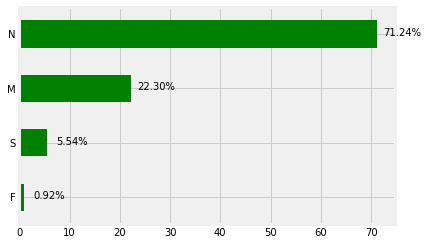

In [6]:
plot_data = create_plot_data(crash_data, 'crashSeverity')
plot_and_annotate(plot_data, color='green')

The first thing that we notice is the astonishing small number of fatal crashes there has been; considering this is data going back to the year 2000. We should also mention that New Zealand has had a consistent policy with regard to transportation and road safety.

Also, it is important to note here –as the NZ Transport Agency warns– that the reporting of crashes increses with their severity. Meaning that all *fatal* crashes have been reported most likely, but at the same time there will be *Non Injury* and *Minor* crashes that weren't reported. This decision falls somewhat to the person in charge of responding to the crash and reporting it.

However, the most important thing to notice is how these classes are distributed and the imbalance between them. Since we want to predict these classes, and because the dispatched response would be very different depending on our prediction, we definitely need to be very careful about how we measure the performance of our model.

To this end, and considering we will be trying different algorithms, we will rely on an array of performance metrics that will help us evaluate and chose the best algorithm for the task. Namely, for each algorithm, we will analyze the following performance metrics:
* Precision
* Recall
* F-Score

#### multiVehicle

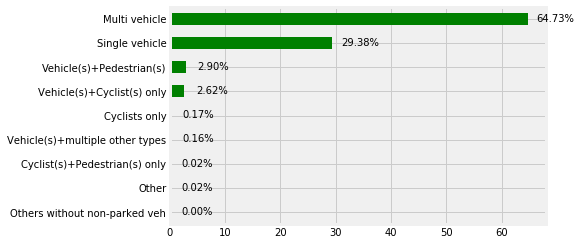

In [7]:
plot_data = create_plot_data(crash_data, 'multiVehicle')
plot_and_annotate(plot_data, color='green')

This feature doesn't raise any alarm or suspitions with regard to its values. But we do take notice of its distribution.

#### holiday

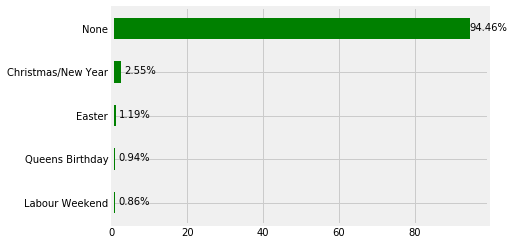

In [8]:
plot_data = create_plot_data(crash_data, 'holiday')
plot_and_annotate(plot_data, color='green')

Here we see that almost all crashes happened on a regular day. One could have assumed this would be different since alcohol consumption levels tend to be higher during any of these holidays.

#### regionDesc

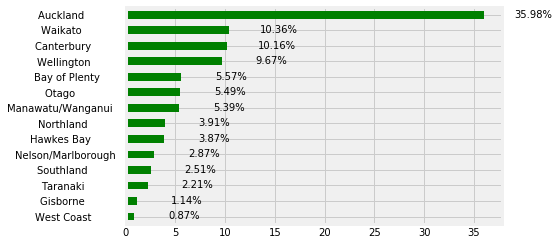

In [9]:
plot_data = create_plot_data(crash_data, 'regionDesc')
plot_and_annotate(plot_data, color='green')

The distribution of values for this features is consistent with population density throughout the country. It will be interesting to see how the other features behave with regard to this one.

#### tlaName

As the catalog describes, this feature indicates the local authority that oversaw the crash and the following procedures. Therefore, for almost every case, the tlaName will be a district withing the region of the crash.

However, for some cases, the tlaName will be a distrcit that doesn't belong to the region indicated for the crash. We understand that these cases correspond to crashes that happened close to the border between two regions and for some unknown reason, the TLA that responded to the crash was from another region from where the crash happened.

In this instance we will consider this as of no consequence. However, it could be necesary to consider treating or removing this feature to reduce the *noise* it might generate.

#### intersection

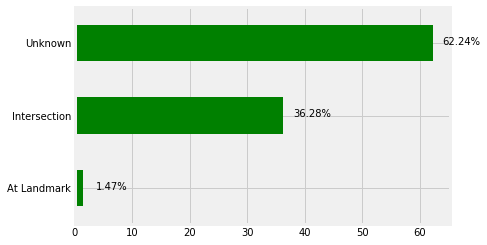

In [10]:
plot_data = create_plot_data(crash_data, 'intersection')
plot_and_annotate(plot_data, color='green')

This feature doesn't present anything strange or special. One could argue though that the value *Unknown* deserves some special treatment. However, the NZ Transport Agency has defined it in the PDF as a proper value, giving it complete legitamecy.

#### junctionType

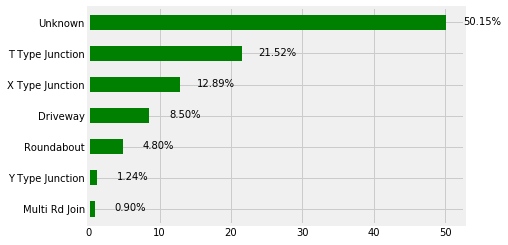

In [11]:
plot_data = create_plot_data(crash_data, 'junctionType')
plot_and_annotate(plot_data, color='green')

Again, as with *intersection*, the value *Unknown* is completely legitimate.

#### cornerRoadSideRoad

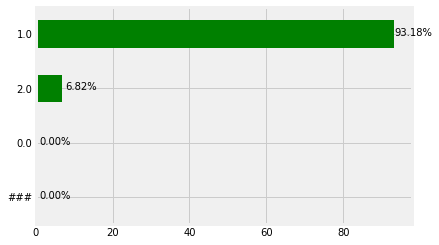

In [12]:
plot_data = create_plot_data(crash_data, 'cornerRoadSideRoad')
plot_and_annotate(plot_data, color='green')

Here we finally see something that required our attention. First, let us clarify that the name of this feature in the dataset corresponds to the feature refered to as Crash *Road Side Road (CR_RD_SIDE_RD)* from the PDF. In the PDF, it says that the possible values are either `1`or `2`. But here we find that there are some samples with values `0` –which comes directly from the dataset– and with `###` –which was our way to denote missing values. In any case, these are samples with values that are not included in the feature's definition.

By looking at the plot above, we see that these two strange values occur on a very small number of samples:

In [13]:
plot_data

cornerRoadSideRoad    percent
1.0              610996  93.182674
2.0               44696   6.816563
0.0                   3   0.000458
###                   2   0.000305

One option would be to remove these five samples from the dataset. Another options would be to fill these cases with an appropriate value. However, we have no criteria to choose such a value. Besides these few cases only represent an infinitesimal portion of the dataset.

As a final check before removing them, let us see what is the creash severity for these cases.

In [14]:
mask = crash_data[crash_data['cornerRoadSideRoad'].isin([0, '###'])]
mask[['cornerRoadSideRoad', 'crashSeverity']]

cornerRoadSideRoad crashSeverity
21021                   0             N
26595                   0             N
547028                ###             N
583837                ###             N
630452                  0             N

Great. They all correspond to *non-injury* cases. Since this is the class that has the most cases and is responsable for most of the imbalance between classes, we can go ahead and remove them without any significant loss of information.

In [15]:
crash_data.drop(mask.index, inplace=True)

#### directionRoleDescription

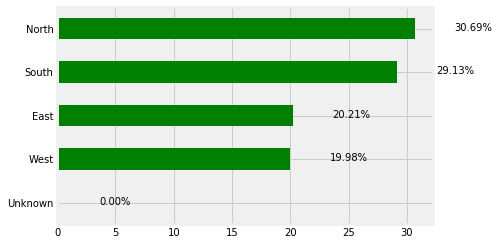

In [16]:
plot_data = create_plot_data(crash_data, 'directionRoleDescription')
plot_and_annotate(plot_data, color='green')

Once again, wee see a value that is not mentioned in the feature's definition: `Unknown`. Also, like before, this value occurs on a very small number of samples. So we repeat the same procedure we followed for the previous feature.

Lets see precisely how many samples are there for this value:

In [17]:
plot_data

directionRoleDescription    percent
North                      201212  30.686969
South                      190989  29.127853
East                       132506  20.208574
West                       130979  19.975690
Unknown                         6   0.000915

Lets check the crash severity for these cases.

In [18]:
mask = crash_data[crash_data['directionRoleDescription'] == 'Unknown']
mask[['directionRoleDescription', 'crashSeverity']]

directionRoleDescription crashSeverity
8023                   Unknown             M
12792                  Unknown             M
27911                  Unknown             N
34749                  Unknown             N
38166                  Unknown             N
67192                  Unknown             N

In this case, the samples are split between *non-injury* and *Minor* crashes. Which are the two majority classes. So again, we can go ahead and remove them.

In [19]:
crash_data.drop(mask.index, inplace=True)

#### crashSHDescription

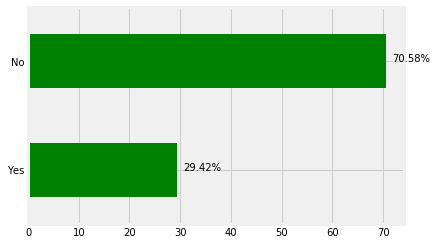

In [20]:
plot_data = create_plot_data(crash_data, 'crashSHDescription')
plot_and_annotate(plot_data, color='green')

This feature doesn't present any strange behaviour.

#### crashRPSH

This feature has so many possible values that plotting them leaves the plot unreadable. Instead, we show the number on samples for each possible value.

In [21]:
plot_data = create_plot_data(crash_data, 'crashRPSH')
plot_data

crashRPSH    percent
0.0      468584  71.464695
###       79452  12.117385
2.0       20114   3.067627
3.0       11243   1.714693
6.0        9721   1.482569
16.0       7908   1.206065
5.0        4017   0.612641
20.0       2864   0.436794
73.0       2760   0.420933
30.0       2598   0.396226
8.0        2458   0.374875
25.0       2269   0.346050
29.0       2228   0.339797
4.0        2128   0.324546
45.0       2101   0.320428
35.0       1754   0.267506
12.0       1704   0.259880
74.0       1670   0.254695
7.0        1498   0.228463
26.0       1485   0.226480
10.0       1422   0.216872
60.0       1391   0.212144
27.0       1391   0.212144
50.0       1391   0.212144
94.0       1240   0.189115
57.0       1158   0.176609
23.0       1061   0.161815
58.0        914   0.139396
75.0        910   0.138786
14.0        844   0.128720
...         ...        ...
93.0        290   0.044228
41.0        282   0.043008
38.0        279   0.042551
24.0        265   0.040416
63.0        253   0.038586
43.0        235   0.035840
67.0        228   0.034773
34.0        226   0.034468
83.0        225   0.034315
82.0        217   0.033095
47.0        211   0.032180
49.0        189   0.028825
28.0        181   0.027605
90.0        163   0.024859
71.0        156   0.023792
21.0        132   0.020132
53.0        130   0.019827
62.0        121   0.018454
80.0        111   0.016929
84.0         89   0.013574
69.0         88   0.013421
37.0         86   0.013116
98.0         77   0.011743
97.0         57   0.008693
86.0         57   0.008693
95.0         56   0.008541
17.0         39   0.005948
78.0         33   0.005033
48.0         30   0.004575
46.0         17   0.002593

[81 rows x 2 columns]

The first thing to notice here, is that 71.5% of all samples have a value of `0`, followed by another 12% that have a value of `### `. Together, these two values account for 83% of the dataset. If we expect to get any value from this feature, we will need to treat these two values.

In doing so, lets remember that this feture is intended to indicate the State Highway where the crash happened; that is for crashes that happened on a SH, of course. So for crashes with `crashSHDescription=No`, it wouldn't make sense to see anything different than our missing value `###` or `0`.

We will first verify this assumption before we focus on samples with `crashSHDescription=Yes`.

In [22]:
sh_crashes = crash_data[crash_data['crashSHDescription'] == 'No']
sh_crash_values = create_count_percentages(sh_crashes['crashRPSH'])
sh_crash_values

crashRPSH    percent
0.0      461987  99.834900
###         276   0.059643
2.0          88   0.019017
3.0          70   0.015127
74.0         35   0.007563
6.0          31   0.006699
18.0         29   0.006267
16.0         27   0.005835
73.0         24   0.005186
29.0         23   0.004970
35.0         16   0.003458
76.0         14   0.003025
5.0          14   0.003025
50.0         11   0.002377
45.0         10   0.002161
54.0         10   0.002161
26.0          9   0.001945
22.0          9   0.001945
25.0          9   0.001945
87.0          5   0.001080
30.0          5   0.001080
57.0          4   0.000864
44.0          3   0.000648
56.0          3   0.000648
10.0          3   0.000648
60.0          3   0.000648
75.0          3   0.000648
88.0          3   0.000648
23.0          3   0.000648
12.0          2   0.000432
20.0          2   0.000432
32.0          2   0.000432
27.0          2   0.000432
94.0          2   0.000432
21.0          1   0.000216
17.0          1   0.000216
98.0          1   0.000216
15.0          1   0.000216
49.0          1   0.000216
11.0          1   0.000216
58.0          1   0.000216
7.0           1   0.000216
63.0          1   0.000216
77.0          1   0.000216
4.0           1   0.000216
79.0          1   0.000216
86.0          1   0.000216
95.0          1   0.000216

Excellent, 99.88% of samples with *crashSHDescription*=`No` have *crashRPSH* equal to `###`or `0`.

We will infer that the samples that do have a specific SH value correspond to the nearest SH from the site of the crash. In any case, we will set a value of `###` for all sample that have `crashSHDescription=NO`, as we want it to carry no relevance for those cases.

In [23]:
crash_data['crashRPSH'] = crash_data.apply(
    lambda row: 'N/A' if row['crashSHDescription'] == 'No' else row['crashRPSH'],
    axis=1)

With that case covered, lets focus now on crashes that did happen on an SH

In [24]:
sh_crashes = crash_data[crash_data['crashSHDescription'] == 'Yes']
sh_crash_values = create_count_percentages(sh_crashes['crashRPSH'])
sh_crash_values

crashRPSH    percent
###       79176  41.037655
2.0       20026  10.379662
3.0       11173   5.791070
6.0        9690   5.022417
16.0       7881   4.084795
0.0        6597   3.419286
5.0        4003   2.074792
20.0       2862   1.483401
73.0       2736   1.418094
30.0       2593   1.343976
8.0        2458   1.274004
25.0       2260   1.171379
29.0       2205   1.142872
4.0        2127   1.102444
45.0       2091   1.083785
35.0       1738   0.900822
12.0       1702   0.882162
74.0       1635   0.847436
7.0        1497   0.775909
26.0       1476   0.765024
10.0       1419   0.735481
27.0       1389   0.719932
60.0       1388   0.719413
50.0       1380   0.715267
94.0       1238   0.641667
57.0       1154   0.598129
23.0       1058   0.548371
58.0        913   0.473216
75.0        907   0.470107
14.0        844   0.437453
...         ...        ...
93.0        290   0.150310
41.0        282   0.146163
38.0        279   0.144608
24.0        265   0.137352
63.0        252   0.130614
43.0        235   0.121803
67.0        228   0.118175
34.0        226   0.117138
83.0        225   0.116620
82.0        217   0.112473
47.0        211   0.109363
49.0        188   0.097442
28.0        181   0.093814
90.0        163   0.084484
71.0        156   0.080856
21.0        131   0.067899
53.0        130   0.067380
62.0        121   0.062715
80.0        111   0.057532
84.0         89   0.046130
69.0         88   0.045611
37.0         86   0.044575
98.0         76   0.039392
97.0         57   0.029544
86.0         56   0.029025
95.0         55   0.028507
17.0         38   0.019696
78.0         33   0.017104
48.0         30   0.015549
46.0         17   0.008811

[81 rows x 2 columns]

Ok, 41% of crashes that happened on an SH don't say on which one. So lets see if we can shed some light on this cases and infer their missing values by looking at `crashLocation1`:

In [25]:
na_samples = sh_crashes[sh_crashes['crashRPSH'] == '###']
na_samples_values = create_count_percentages(na_samples['crashLocation1'])
na_samples_values

crashLocation1    percent
SH 1N                            52737  66.607305
SH 1S                            16953  21.411791
SH 6A                              610   0.770435
SH 30A                             547   0.690866
SH 1B                              516   0.651713
SH 25A                             473   0.597403
SH 50A                             428   0.540568
SH 2A                              424   0.535516
SH 20A                             402   0.507730
SH 1N VIVIAN                       222   0.280388
SH 1S MAIN SOUTH                   192   0.242498
SH 29A                             184   0.232394
SH 20B                             171   0.215975
SH 3A                              135   0.170506
SH 1N COBHAM                       127   0.160402
SH 1S CARMEN                       127   0.160402
SH 1S RUSSLEY                      125   0.157876
SH 2B                              121   0.152824
SH 1N RUGBY                        115   0.145246
SH 1S JOHNS                         94   0.118723
SH 1N VICTORIA                      71   0.089674
SH 1N RUAHINE                       68   0.085885
SH 1N CALABAR                       67   0.084622
SH 1N WELLINGTON                    65   0.082096
SH 74A                              63   0.079570
SH 1N GREAT SOUTH                   61   0.077044
SH 1N KARO                          58   0.073255
SH 1N SUSSEX                        57   0.071992
SH 1S MAIN NORTH                    55   0.069465
SH 7A                               52   0.065676
...                                ...        ...
ACCESS ROAD                          1   0.001263
EVANS ST                             1   0.001263
WILSON ROAD                          1   0.001263
KOPUTAROA ROAD                       1   0.001263
SH 1N TAURIMA ST                     1   0.001263
SH 1N VIVICAN ST                     1   0.001263
KILLARNEY ST                         1   0.001263
SH 1S BRIDGE                         1   0.001263
ABBOTS WAY                           1   0.001263
FLETCHER ST                          1   0.001263
FENTON ST S                          1   0.001263
HAUTAPU ST                           1   0.001263
SH 1N COBHAH                         1   0.001263
ASHWORTH ST                          1   0.001263
MURDOCH CRESCENT N                   1   0.001263
ALBANY HIGHWAY OFF WBD               1   0.001263
SH 1S ASHWORTHS                      1   0.001263
EAST ST N                            1   0.001263
WEEDONS ROAD                         1   0.001263
GREVILLE OFF NBD                     1   0.001263
CARMEN ROAD                          1   0.001263
SH 1S WAIHOLA HIGHWAY                1   0.001263
TAURIMA ST                           1   0.001263
MILL ON NBD                          1   0.001263
WELLINGTON ON NBD                    1   0.001263
OTARA ON SBD                         1   0.001263
SH 1B TAYLOR GORDONTON               1   0.001263
OTEHA VALLEY ON SBD                  1   0.001263
DAVIES ROAD                          1   0.001263
GREENLEA LANE                        1   0.001263

[901 rows x 2 columns]

This is great, almost 90% of all `###` crashes actually happened on SH1 (either nort or south). So lets go ahead and insert this value:

In [26]:
crash_data['crashRPSH'] = crash_data.apply(
    lambda row: 1 if row['crashSHDescription'] == 'Yes' and row['crashLocation1'] in ('SH 1N', 'SH 1S') else row['crashRPSH'],
    axis=1
)

Now we need to compute again the data from above to update our picture of the missing values

In [27]:
sh_crashes = crash_data[crash_data['crashSHDescription'] == 'Yes']
sh_crash_values = create_count_percentages(sh_crashes['crashRPSH'])
sh_crash_values

crashRPSH    percent
1         69932  36.246404
2.0       20024  10.378625
3.0       11154   5.781222
6.0        9677   5.015679
###        9486   4.916682
16.0       7881   4.084795
0.0        6517   3.377822
5.0        3988   2.067017
20.0       2862   1.483401
73.0       2735   1.417576
30.0       2592   1.343458
8.0        2454   1.271931
25.0       2260   1.171379
29.0       2201   1.140799
4.0        2127   1.102444
45.0       2091   1.083785
35.0       1738   0.900822
12.0       1699   0.880607
74.0       1635   0.847436
7.0        1495   0.774872
26.0       1469   0.761396
10.0       1414   0.732889
27.0       1389   0.719932
60.0       1388   0.719413
50.0       1380   0.715267
94.0       1238   0.641667
57.0       1154   0.598129
23.0       1051   0.544743
75.0        907   0.470107
58.0        898   0.465442
...         ...        ...
93.0        288   0.149273
41.0        282   0.146163
38.0        279   0.144608
24.0        265   0.137352
63.0        252   0.130614
43.0        235   0.121803
67.0        228   0.118175
34.0        226   0.117138
83.0        222   0.115065
82.0        217   0.112473
47.0        211   0.109363
49.0        188   0.097442
28.0        181   0.093814
90.0        162   0.083966
71.0        156   0.080856
21.0        131   0.067899
53.0        130   0.067380
62.0        113   0.058569
80.0        111   0.057532
84.0         89   0.046130
69.0         88   0.045611
37.0         86   0.044575
98.0         76   0.039392
97.0         57   0.029544
95.0         55   0.028507
86.0         55   0.028507
17.0         30   0.015549
48.0         30   0.015549
78.0         29   0.015031
46.0         16   0.008293

[82 rows x 2 columns]

We still have some cases that need our attention. From all crshes with `crashSHDescription=Yes`, there are still 4.9% of samples with `crashRPSH=###` and another 3.4% with `crashRPSH=0`. 

In fact, lets check if we see any other strange value.

In [28]:
sh_crash_values.index

Index([    1,   2.0,   3.0,   6.0, '###',  16.0,   0.0,   5.0,  20.0,  73.0,
        30.0,   8.0,  25.0,  29.0,   4.0,  45.0,  35.0,  12.0,  74.0,   7.0,
        26.0,  10.0,  27.0,  60.0,  50.0,  94.0,  57.0,  23.0,  75.0,  58.0,
        14.0,  36.0,  18.0,  54.0,  39.0,  22.0,  11.0,  76.0,  87.0,  44.0,
        99.0,  15.0,  33.0,  56.0,  88.0,  77.0,  96.0,  32.0,  79.0,  31.0,
        85.0,  65.0,  93.0,  41.0,  38.0,  24.0,  63.0,  43.0,  67.0,  34.0,
        83.0,  82.0,  47.0,  49.0,  28.0,  90.0,  71.0,  21.0,  53.0,  62.0,
        80.0,  84.0,  69.0,  37.0,  98.0,  97.0,  95.0,  86.0,  17.0,  48.0,
        78.0,  46.0],
      dtype='object')

Good, those are the only two.

Would it be possible to simply drop these samples?

First of all, of how many samples are we talking about?

In [29]:
p = sh_crashes[sh_crashes['crashRPSH'] == '###'].shape[0] / crash_data.shape[0] * 100
printmd('the remaining `###` samples represent {:.2f}% of the whole dataset'.format(p))

the remaining `###` samples represent 1.45% of the whole dataset

In [30]:
p = sh_crashes[sh_crashes['crashRPSH'] == 0].shape[0] / crash_data.shape[0] * 100
printmd('the remaining `0` samples represent {:.2f}% of the whole dataset'.format(p))

the remaining `0` samples represent 0.99% of the whole dataset

If we want to remove these samples, we should first check if this action would affect the balance and distribution of our target featrure, `crashSeveriry`:

In [31]:
def compute_percent_total(row):
    return row['crashSeverity'] / crash_data[crash_data['crashSeverity'] == row.name].shape[0] * 100

counts = create_count_percentages(sh_crashes[sh_crashes['crashRPSH'] == '###']['crashSeverity'])
counts['percent_total'] = counts.apply(compute_percent_total, axis=1)
counts

crashSeverity    percent  percent_total
N           6953  73.297491       1.488451
M           2015  21.241830       1.378315
S            445   4.691124       1.224883
F             73   0.769555       1.210012

In [32]:
counts = create_count_percentages(sh_crashes[sh_crashes['crashRPSH'] == 0]['crashSeverity'])
counts['percent_total'] = counts.apply(compute_percent_total, axis=1)
counts

crashSeverity    percent  percent_total
N           5325  81.709375       1.139940
M           1031  15.820163       0.705232
S            147   2.255639       0.404624
F             14   0.214823       0.232057

This is very good news. For both cases, the remaining samples are distributed across our target feature in the same way. Notice how, for each `crashSeverity` value, the samples represent between 1,2% and 1.5% of each class; and between 0.2% and 1.1%, respectively for each value (`###`and `0`).

We conclude that dropping these remaining samples from the dataset will not alter the balance of classes of the target feature. We could call it a stratified trimming of the dataset.

In [33]:
mask = crash_data.loc[(crash_data['crashSHDescription'] == 'Yes') & (crash_data['crashRPSH'].isin([0, '###']))]
crash_data.drop(mask.index, inplace=True)

phew!

We have treated all strange and missing values by analyzing the relevant samples and their corresponding context. Now, the feature can be used in the final model... *CrashRPSH*: Done!

#### flatHill

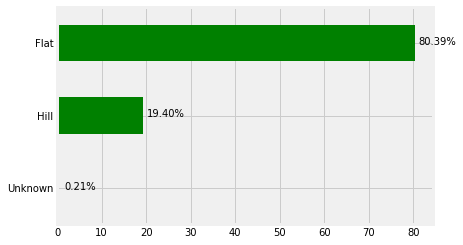

In [34]:
plot_data = create_plot_data(crash_data, 'flatHill')
plot_and_annotate(plot_data, color='green')

Ok. How many sample are there with a value `Unknown`?

In [35]:
plot_data

flatHill    percent
Flat       514254  80.392007
Hill       124089  19.398515
Unknown      1340   0.209479

What are the incidence of these samples across the target feature?

In [36]:
unknowns = crash_data[crash_data['flatHill'] == 'Unknown']
create_count_percentages(unknowns['crashSeverity'])

crashSeverity    percent
N           1029  76.791045
M            239  17.835821
S             66   4.925373
F              6   0.447761

Again, the inconsistent samples are distributed across the target variable in such a way that removing them from the dataset wouldn't alter the balance of the classes we intend to predict. Lets remove them.

In [37]:
crash_data.drop(unknowns.index, inplace=True)

#### roadCharacter

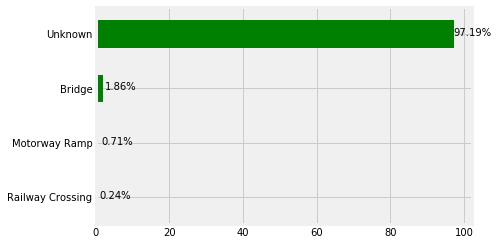

In [38]:
plot_data = create_plot_data(crash_data, 'roadCharacter')
plot_and_annotate(plot_data, color='green')

In this case again, `Unknown` is a legitiamte value.

#### roadCurvature

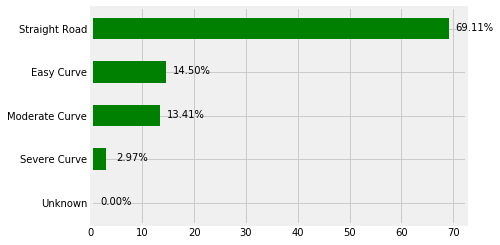

In [39]:
plot_data = create_plot_data(crash_data, 'roadCurvature')
plot_and_annotate(plot_data, color='green')

Lets repeat the process as for `flatHill`:
* Check how many samples are there with a value `Unknown` .
* Check for the severity of those crashes.
* If possible, remove the samples altogether.

In [40]:
plot_data

roadCurvature    percent
Straight Road          441180  69.113314
Easy Curve              92575  14.502391
Moderate Curve          85613  13.411755
Severe Curve            18973   2.972227
Unknown                     2   0.000313

In [41]:
unknowns = crash_data[crash_data['roadCurvature'] == 'Unknown']
create_count_percentages(unknowns['crashSeverity'])

crashSeverity  percent
N              2    100.0

In [42]:
crash_data.drop(unknowns.index, inplace=True)

#### roadLane

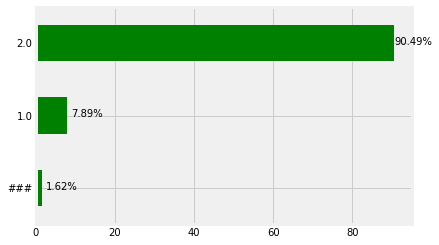

In [43]:
plot_data = create_plot_data(crash_data, 'roadLane')
plot_and_annotate(plot_data, color='green')

At this point, we have kind of a recipe to deal with these inconsistent values. At least until we cannot remove the samples.

In [44]:
plot_data

roadLane    percent
2.0    577631  90.489409
1.0     50391   7.894057
###     10319   1.616534

In [45]:
missing = crash_data[crash_data['roadLane'] == '###']
create_count_percentages(missing['crashSeverity'])

crashSeverity    percent
N           7822  75.801919
M           1747  16.929935
S            672   6.512259
F             78   0.755887

In [46]:
crash_data.drop(missing.index, inplace=True)

At this point, we should mention that a more thorugh analysis of the dataset could allow us to fill in the blanks of all this missing values and avoid dropping their samples. However due to a time constraint, and to keep our focus on building the model, we have decided to take this route.

#### roadMarkings

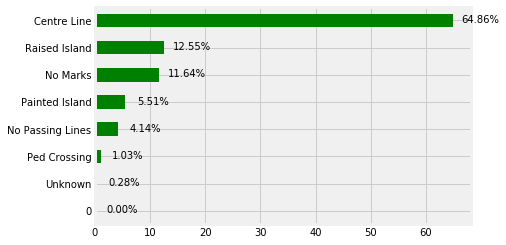

In [47]:
plot_data = create_plot_data(crash_data, 'roadMarkings')
plot_and_annotate(plot_data, color='green')

In [48]:
plot_data

roadMarkings    percent
Centre Line             407305  64.855212
Raised Island            78812  12.549242
No Marks                 73127  11.644019
Painted Island           34579   5.506017
No Passing Lines         25977   4.136320
Ped Crossing              6477   1.031333
Unknown                   1744   0.277697
0                            1   0.000159

In [49]:
zero = crash_data[crash_data['roadMarkings'] == '0']
create_count_percentages(zero['crashSeverity'])

crashSeverity  percent
N              1    100.0

In [50]:
crash_data.drop(zero.index, inplace=True)

#### roadSurface

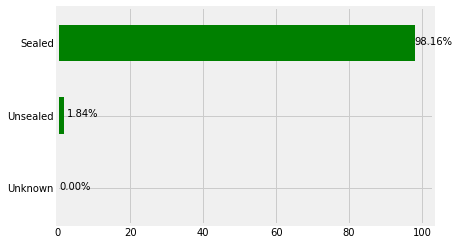

In [51]:
plot_data = create_plot_data(crash_data, 'roadSurface')
plot_and_annotate(plot_data, color='green')

In [52]:
plot_data

roadSurface    percent
Sealed         616468  98.160412
Unsealed        11552   1.839429
Unknown             1   0.000159

In [53]:
unknowns = crash_data[crash_data['roadSurface'] == 'Unknown']
create_count_percentages(unknowns['crashSeverity'])

crashSeverity  percent
N              1    100.0

In [54]:
crash_data.drop(unknowns.index, inplace=True)

#### roadWet

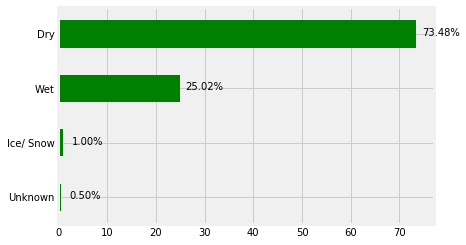

In [55]:
plot_data = create_plot_data(crash_data, 'roadWet')
plot_and_annotate(plot_data, color='green')

`Unknown` is admissible. Moving along.

#### numberOfLanes

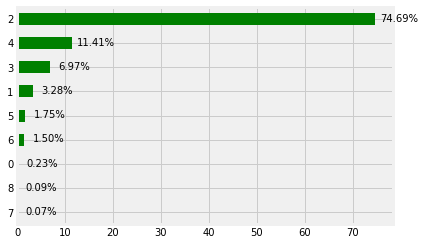

In [56]:
plot_data = create_plot_data(crash_data, 'numberOfLanes')
plot_and_annotate(plot_data, color='green')

Hm... here the only strange values would be `0`. How can a road, street or highway have zero lanes?

In [57]:
plot_data

numberOfLanes    percent
2         469081  74.692048
4          71681  11.413808
3          43768   6.969205
1          20605   3.280946
5          11004   1.752173
6           9423   1.500430
0           1434   0.228337
8            577   0.091876
7            447   0.071176

In [58]:
zeros = crash_data[crash_data['numberOfLanes'] == 0]
create_count_percentages(zeros['crashSeverity'])

crashSeverity    percent
N           1044  72.803347
M            297  20.711297
S             86   5.997211
F              7   0.488145

In [59]:
crash_data.drop(zeros.index, inplace=True)

#### trafficControl

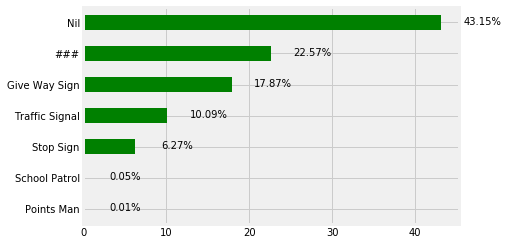

In [60]:
plot_data = create_plot_data(crash_data, 'trafficControl')
plot_and_annotate(plot_data, color='green')

For this particular feature, we should mention that the value `Nil` is very important. It indicates that place where the crash happened didn't have any traffic control signals. This could turn out to be a significat factor for the crash severity and it could be an *easy* way to reduce fatalities and crashes overall. However, a sample with no value for this feature is problematic.

Lets check the severity of crashes without a value for it:

In [61]:
missing = crash_data[crash_data['trafficControl'] == '###']
create_count_percentages(missing['crashSeverity'])

crashSeverity    percent
N          95805  67.754597
M          33531  23.713579
S          10603   7.498586
F           1461   1.033239

In this case we cannot simply remove the samples. What's more we don't have straight way of infering a value for these samples. Therefore, we will the value N/A as it is and let the final model account for it.

<u>**Note:**</u> It is important to say that were it not for the time constraint mentioned earlier, we should dig deeper into this feture in order to arrive at a better solution since the feature carries much value towards our goal.

In [62]:
crash_data['trafficControl'] = crash_data.apply(
    lambda row: 'N/A' if row['crashSHDescription'] == 'No' else row['trafficControl'],
    axis=1)

#### urban

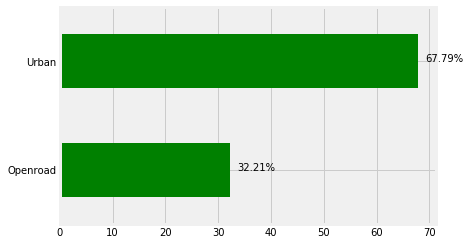

In [63]:
plot_data = create_plot_data(crash_data, 'urban')
plot_and_annotate(plot_data, color='green')

Nothing out of the ordinary, moving to the next one

#### Light

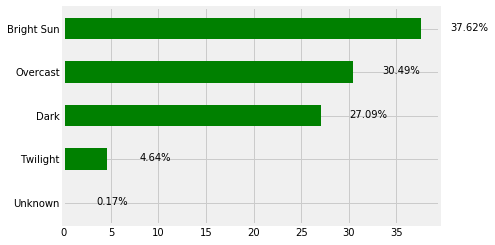

In [64]:
plot_data = create_plot_data(crash_data, 'light')
plot_and_annotate(plot_data, color='green')

#### streetLight

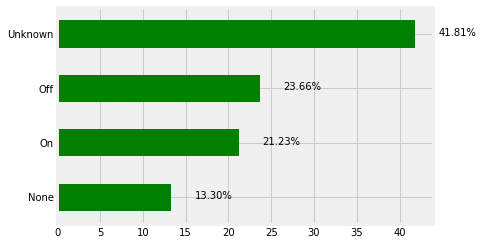

In [65]:
plot_data = create_plot_data(crash_data, 'streetLight')
plot_and_annotate(plot_data, color='green')

Although this feautre doesn't present any inconsistent values with its definition, the high number of crashes with `Unknown` does raise questions.

#### weatherA

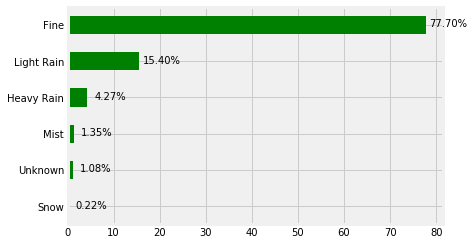

In [66]:
plot_data = create_plot_data(crash_data, 'weatherA')
plot_and_annotate(plot_data, color='green')

#### weatherB

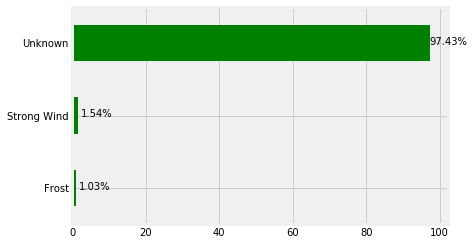

In [67]:
plot_data = create_plot_data(crash_data, 'weatherB')
plot_and_annotate(plot_data, color='green')

---

After reviewing all the categorical features, our dataset has changed a bit:

In [68]:
print('The dataset has {:3,d} samples and {} features'.format(*crash_data.shape))

The dataset has 626,586 samples and 68 features


We have dropped 4.6% of the samples due to inconsistent values and we have dropped 11 features that weren't meaning ful. The next step is to check a few numerical features.

### 3.2 Numerical Feature

We won't be checking all numerical features, many of them are just counters for number of different kind of object that were hit in the crash. But there are a few that we should check at least.

#### speedLimit

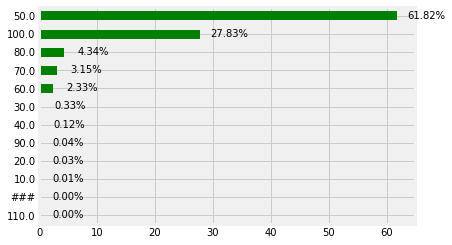

In [69]:
plot_data = create_plot_data(crash_data, 'speedLimit')
plot_and_annotate(plot_data, color='green')

This looks nice. Excep for the very few cases that are missing a value. Lets check the severity of those crashes to see if we can drop the samples.

In [70]:
missing = crash_data[crash_data['speedLimit'] == '###']
create_count_percentages(missing['crashSeverity'])

crashSeverity  percent
N              8     80.0
M              1     10.0
S              1     10.0

Given the few cases there are, we remove the samples.

In [71]:
crash_data.drop(missing.index, inplace=True)

#### advisorySpeed

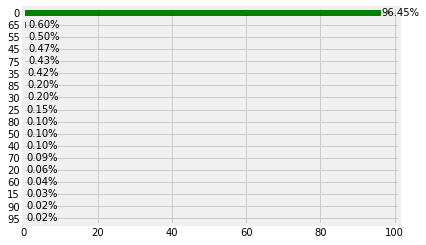

In [72]:
plot_data = create_plot_data(crash_data, 'advisorySpeed')
plot_and_annotate(plot_data, color='green')

Here we clearly see that this features is being used properly; as it makes no sense to advise a speed of `0` (Mk/Hr) on 96% of cases.

So we will simply drop the feature from the dataset.

In [73]:
crash_data.drop('advisorySpeed', axis=1, inplace=True)

#### temporarySpeedLimit

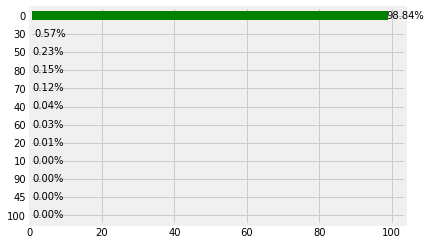

In [74]:
plot_data = create_plot_data(crash_data, 'temporarySpeedLimit')
plot_and_annotate(plot_data, color='green')

Same thing as before. We remove the feature from the dataset.

In [75]:
crash_data.drop('temporarySpeedLimit', axis=1, inplace=True)

---

### 3.3 Wrap up

Great. We have removed two more features, but we haven't dropped any further samples.

As we can see, althoguh the last three features are numerical, they actualy could be intepreted as categorical (ordinal) features. In fact, that's what we will do. All the remaining features are counts to describe the amount of objects/vehicles/people involved in the crash. As such, we will treat them as numerical.

ALso, **_crashLocation1_**, **_crashLocation2_** present such a varied array of values which are subject to the point of view of the officer that reported each crash that we simply cannot use them for our analysis or model

In [76]:
crash_data.drop(['crashLocation1', 'crashLocation2'], axis=1, inplace=True)

In [77]:
# Read features descriptions
features_catalog = pd.read_table('data/features_description.tsv')
crash_data = cast_df_features(crash_data, features_catalog)

We will use a feature catalog, which is a distilled version of the PDF from above. The catalog will be useful to keep track of all the features, their meaning and type, and the data type of their values. we will use it as a reference throughout the project and it will be useful should you have any question about the dataset.

The catalog is a tab-separated file named *features_description.tsv*. You ca find in the root of the project's repository.

This concludes our cleaning tasks and we can now start exploring the structure of the dataset and the relation between the features. But before we do that, lets save the clean dataset so we don't have to go through all this process again when feeding it to the model. This will help reduce training time and could also add to the accuracy and efficiency of the model.

In [78]:
crash_data.to_csv('data/Crash_Analysis_System_CAS_data_clean.csv', index=False)

## 4. Correlation of Features

In this section we will explore the relationship between features. Specifically, we present a Chi2 test of independence for each pair of categorical features.

In [80]:
# available_features = [feature for feature in features_catalog['feature_name'] if feature in crash_data.columns]

# chi2_matrix = []
# index = []

# for feature_a in available_features:
#     index.append(feature_a)
#     row = []
#     for feature_b in available_features:
#         contingency = pd.crosstab(crash_data[feature_a],
#                                   crash_data[feature_b])
#         #acceptance level is 0.05
#         p = chi2_contingency(contingency)[1]
#         row.append(p)
#     chi2_matrix.append(row)
    
# chi2_p_values = pd.DataFrame(chi2_matrix, columns=index, index=index)
# chi2_p_values.to_csv('chi2_independence_results.csv')
chi2_p_values = pd.read_csv('data/chi2_independence_results.csv', index_col=0)

next, we show the P values corresponding to the test for each pair of features. Naturally, every element in the diagonal will have a value of 0 since any given features will be totally dependent on itself.

The values should be interpreted as the probability that a Chi2 test for the complete population of crashes be greater than the one found using the (sample) dataset. In other words, how likely is it to find values different than the ones found using the provided crash samples?

If the value is greated than a given treashold –in this case 0.05, or 5%– then the two features will be deemed as independent. If the P value is lower than 0.05, the two features will be considered as mutually dependant.

For a better visualization of these values we include an image generated from the Tableau workbook –available on Tableau Public. Due to a time contraint, we don't include the necesary code to reproduce the viz using matplotlib.

In [81]:
chi2_p_values

cornerRoadSideRoad      crashRPSH  crashSeverity  \
cornerRoadSideRoad              0.000000e+00   0.000000e+00   1.269356e-64   
crashRPSH                       0.000000e+00   0.000000e+00   0.000000e+00   
crashSeverity                   1.269356e-64   0.000000e+00   0.000000e+00   
crashSHDescription              0.000000e+00   0.000000e+00   0.000000e+00   
darkLight                       2.132818e-74   1.199965e-91  1.263091e-175   
directionRoleDescription        0.000000e+00   0.000000e+00   6.312706e-08   
flatHill                        0.000000e+00   0.000000e+00  9.175632e-266   
holiday                         9.809611e-02  3.501380e-246   2.605378e-24   
intersection                    0.000000e+00   0.000000e+00   0.000000e+00   
intersectionMidblock            0.000000e+00   0.000000e+00   0.000000e+00   
junctionType                    0.000000e+00   0.000000e+00   0.000000e+00   
light                           3.975686e-81  1.482057e-303  1.291457e-239   
multiVehicle                    1.494880e-77   0.000000e+00   0.000000e+00   
regionDesc                      0.000000e+00   0.000000e+00   0.000000e+00   
roadCharacter                  4.767179e-107   0.000000e+00   1.772201e-92   
roadCurvature                  6.240485e-125   0.000000e+00   0.000000e+00   
roadLane                       5.351640e-133   0.000000e+00   0.000000e+00   
roadMarkings                    0.000000e+00   0.000000e+00   0.000000e+00   
roadSurface                     3.068064e-92   0.000000e+00  2.056823e-130   
roadWet                         3.935545e-51   0.000000e+00  9.550689e-208   
streetLight                     0.000000e+00   0.000000e+00   0.000000e+00   
tlaName                         0.000000e+00   0.000000e+00   0.000000e+00   
trafficControl                  0.000000e+00   0.000000e+00   0.000000e+00   
urban                           0.000000e+00   0.000000e+00   0.000000e+00   
weatherA                        1.339481e-16   0.000000e+00  2.658475e-260   
weatherB                        1.133729e-39   0.000000e+00   6.087496e-46   
numberOfLanes                   4.791577e-96   0.000000e+00   0.000000e+00   
speedLimit                      0.000000e+00   0.000000e+00   0.000000e+00   
animals                         2.360337e-02   4.488772e-02   6.210533e-01   
bridge                          1.546950e-29   0.000000e+00  2.537897e-146   
...                                      ...            ...            ...   
houseBuilding                  8.090935e-155  5.333325e-111   9.182041e-06   
kerb                           1.694793e-143   1.094627e-97   3.360016e-04   
objectThrownOrDropped           3.480381e-05   5.994728e-46   2.677868e-08   
other                           6.363035e-01   5.039270e-56   8.416467e-11   
overBank                        2.662979e-81   0.000000e+00   0.000000e+00   
parkedVehicle                  1.200750e-149   0.000000e+00   0.000000e+00   
phoneBoxEtc                     3.509520e-29   4.140783e-23   2.905975e-05   
postOrPole                      8.202438e-38  6.059443e-154  7.253386e-169   
roadworks                       4.280713e-02   5.651908e-02   1.762758e-01   
slipFlood                       4.700703e-07  2.378409e-102   8.742355e-01   
strayAnimal                     8.526479e-92   0.000000e+00   9.491474e-75   
trafficIsland                  2.374100e-116   1.906011e-16   2.475637e-07   
trafficSign                     1.255637e-52  4.151235e-124   4.249954e-08   
train                           3.874291e-06   9.843832e-09  2.337342e-144   
tree                            6.341730e-01  1.471506e-212   0.000000e+00   
vehicle                         1.090878e-02   6.942691e-25   3.292618e-10   
waterRiver                      7.040985e-10  8.448550e-240   0.000000e+00   
bicycle                         1.521609e-31   0.000000e+00   0.000000e+00   
bus                             3.934235e-03  7.430789e-123   2.981337e-10   
carStationWagon                6.409749e-266   0

<img src="images/chi2_p_values.png" />

Next, we present the same view as above buy with a treashold of 0.05 filter in order to be able to quickly identify the indpendent pair of features

<img src="images/chi2_p_values_mask.png" />

As we can see, there is no single feature that is independant from every other feature, except for `otherVehicleType` and maybe `animals`. However, the most important detail to note here, is the fact that crashSeverity is dependant on almost every feature.

This means that if we choose to remove any additional feature we would be removing information somewhat valuable for our model to use.

At this point we can start to guess what sort of algorithms might turn out to be a good fit for this problem. Specifically, we will first implement a Naive Bayes Algorithms to be used as a benchmark; then we will try different ensemble methods based on tree classifiers as we suspect they could yield good precision and recall.

## 5. Exploratory Visualization

We defer the visual exploration of the dataset to a Tableau workbook published on Tableau Public and available for download here:

https://public.tableau.com/views/NZCrashAnalysisSystem2000-2018Q2/CrashesperRegion?:embed=y&:display_count=yes

The workbook has some navigation controls that will allow for a deeper exploration of the data.

The workbook offers three dashboards. The first one called *Crashe per Region* presents the total number of crashes per region.

Interestingly, Waikato has the most fatal crashes, closely followed by Auckland and Canterbury.
All other severity levels show similar distribution with Auckland, Waikato, Canterbury and Wellington showing the highest concentrations, in that order.

<img src="images/crashes_per_region.png" />

The second dashboard marks each crash in a map, colored by its severity and also presents –for each region– the top 5 locations with the most number of crashes. The map and the list are linked to offered a more interactive exploration.

<img src="images/crash_locations_by_region_and_severity.png" />

The third dashboard shows the distribution of 8 different feature with regard to Crash Severity. Showing that–for each of these features– the distribution is very similar across crash Severity levels. This can be visualized by noting how similar are the 4 color bars (one for each crash severity level), in each feature's chart. Additionally, there's a region filters that allows to look at a specific region. This filter can be used to also see that all regions behave more or less the same.

<img src="images/single_feature_distribution.png" />

These three dashbaord provide a great overview on the behavior of the dataset. Although we were note able to identify a specific characteristic that could help us understand what drives a given crash severity level; we do notice that there's a common trend both across crash severity levels and regions.

This trend motivates us to explore the data with more powerful techniques. Specifically, our next step will be to try to reduce the dimensionality by applying PCA –after applying One Hot Enconding to our categorical features.

---

## 6. Dimensionality Reduction

First lets encode the data so that we can feed it to PCA.

In [82]:
crash_data_ohe = create_one_hot_encoding(crash_data, features_catalog)

In [83]:
y = crash_data_ohe['crashSeverity']
X = crash_data_ohe.drop('crashSeverity', axis=1)

### PCA

In [84]:
pca = PCA(n_components=10, random_state=42)
reduced = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[  9.77813916e-01   2.20478728e-03   1.52877400e-03   1.31933932e-03
   1.29653141e-03   1.28370611e-03   9.83559794e-04   8.82282658e-04
   6.95118783e-04   5.89259685e-04]


In [85]:
reduced_df = pd.DataFrame(reduced)
column_map = {i: 'PC{}'.format(i + 1) for i in reduced_df.columns}
reduced_df.rename(mapper=column_map, copy=False, inplace=True, axis=1)
reduced_df['target'] = y

As we mentioned above, high correlation between features can throw PCA off. But in this case, we should also account for scaling values in our data. Since we have run our data through One Hot Encoding, our data now has a lot of boolean features plus some numerical ones.

These reasons combined can be responsible for having the first principal component explaining 97.7% of total variance in the data.

Regardless, if we see the first two component we get the the same image for all classes.

**plotting them all at once will end up showing only the *Non Injury* due to class imbalance.**

<img src="images/pca_1_pca2_dashboard.png" />

Next we see if by scaling all the features we can get a better results at uncovering latent features.

In [86]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

reduced_scaled = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)

[ 0.14209255  0.07816058  0.06734782  0.06223127  0.05095299  0.04131367
  0.03082423  0.02989217  0.02818863  0.02408065]


In [87]:
reduced_scaled_df = pd.DataFrame(reduced_scaled)
column_map = {i: 'PC{}'.format(i + 1) for i in reduced_scaled_df.columns}
reduced_scaled_df.rename(mapper=column_map, copy=False, inplace=True, axis=1)
reduced_scaled_df['target'] = y

Unfortunately now, our first two PCs account only for 23% of total variance in the data. Thus, they might not be as predictable of the target variable as we hoped they would be. In fact, when we see the same scatter plot but for the sclaed features, we see a picture that is less interpretable than the previous one:

<img src="images/pca_1_pca2_scaled_dashboard.png" />

Unfortunately, PCA has not given us usefull features for our classification goal. This could be due to the available features not being good predictor for the target variable. We will keep this option in mind as we implement the different classification algorithms on our second notebook.